In [1]:
import numpy as np
import config as c
import matplotlib.pyplot as plt
import assim_tools
import sys, os, time

In [2]:
comm = assim_tools.parallel_start()
nproc = 9
comm.size = nproc

In [4]:
state_info = assim_tools.parse_state_info(c)

In [5]:
state_info

{'nx': 1667,
 'ny': 1500,
 'nens': 100,
 'size': 1050476800,
 'fields': {0: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -1,
   'pos': 0},
  1: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -2,
   'pos': 10504768},
  2: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k': -3,
   'pos': 21009536},
  3: {'name': 'ocean_velocity',
   'source': 'topaz.v5',
   'dtype': 'float',
   'is_vector': True,
   'units': 'm/s',
   'err_type': 'normal',
   'time': datetime.datetime(2023, 10, 23, 0, 0),
   'dt': 6.0,
   'k

In [6]:
nfld = len(state_info['fields'])
nens = c.nens
ny, nx = c.grid.x.shape

In [7]:
fld_list = [(m, f) for m in range(nens) for f in range(nfld)]
fld_list_proc = assim_tools.distribute_tasks(comm, fld_list)

In [8]:
np.max([len(fld_lst) for pid,fld_lst in fld_list_proc.items()])

1667

In [12]:
nx_tile = int(np.round(np.sqrt(nx*ny/nproc/3)))
#nx_tile = int(np.round(c.dx_tile/c.dx))
tile_list = [(i, np.minimum(i+nx_tile, nx), j, np.minimum(j+nx_tile, ny))
             for j in np.arange(0, ny, nx_tile) for i in np.arange(0, nx, nx_tile)]
mask = c.mask
nloc_tile = np.array([np.sum((~mask[j1:j2, i1:i2]).astype(int)) for i1,i2,j1,j2 in tile_list])
nobs_tile = 0
load_on_tile = np.maximum(nloc_tile, 1) * np.maximum(nobs_tile, 1)
tile_list_proc = assim_tools.distribute_tasks(comm, tile_list, load_on_tile)

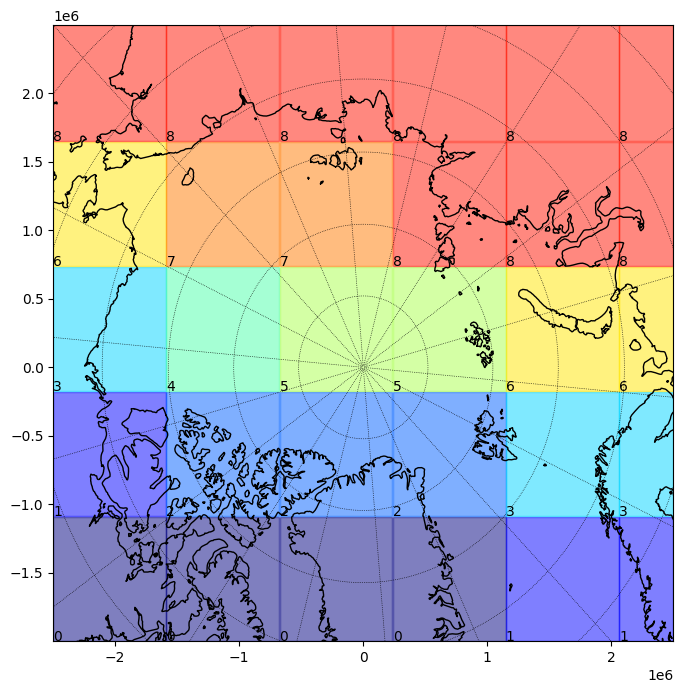

In [13]:
##show load on map
fig, ax = plt.subplots(1, 1, figsize=(8,8))

c.grid.plot_land(ax)

cmap = [plt.cm.jet(x) for x in np.linspace(0, 1, nproc+1)]

x_ = c.grid.x[0, :]
y_ = c.grid.y[:, 0]
for p_id, t_list in tile_list_proc.items():
    for i1,i2,j1,j2 in t_list:
        ax.fill([x_[i1], x_[i1], x_[i2-1], x_[i2-1], x_[i1]], [y_[j1], y_[j2-1], y_[j2-1], y_[j1], y_[j1]], color=cmap[p_id], alpha=.5)
        ax.text(x_[i1], y_[j1], '{}'.format(p_id))

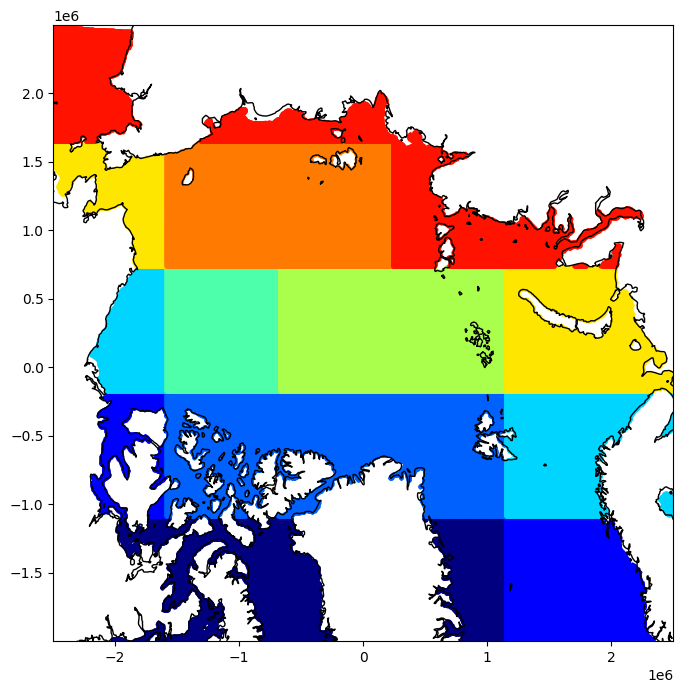

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

c.grid.plot_land(ax, showgrid=False)

for proc_id in range(nproc):
    for i1,i2,j1,j2 in tile_list_proc[proc_id]:
        ii_tile, jj_tile = np.meshgrid(np.arange(i1,i2), np.arange(j1,j2))
        ind = ~mask[j1:j2, i1:i2]
        ax.scatter(x_[ii_tile[ind]], y_[jj_tile[ind]], 3, color=cmap[proc_id])

In [23]:
fld_id = [i for i,r in field_info['fields'].items() if r['name']=='ocean_velocity' and r['k']==-1][0]
mem_id = 0

In [24]:
mem_id, fld_id

(0, 0)

In [ ]:
proc_id = 8
state = np.load('/cluster/work/users/yingyue/dat.{:04d}.npz'.format(proc_id), allow_pickle=True)['state'].item()

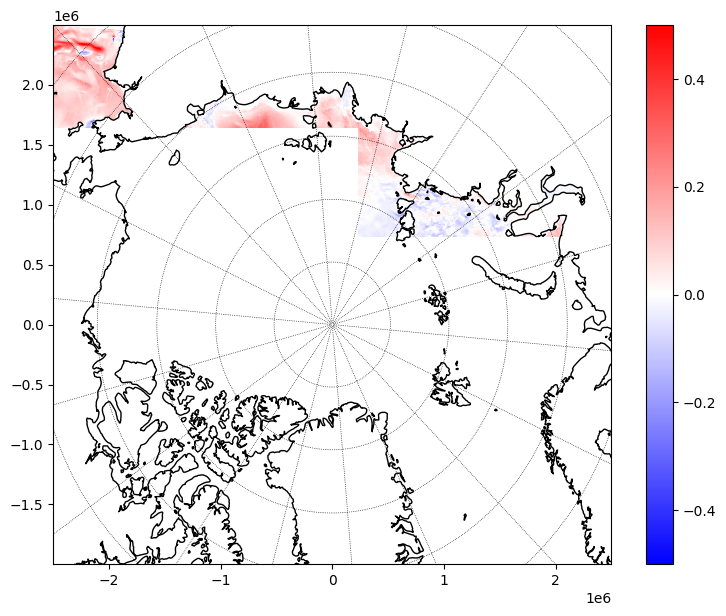

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(9,7))

out = np.full((2, ny, nx), np.nan)

for tile_id in state[mem_id, fld_id]:
    istart,iend,jstart,jend = tile_list_proc[proc_id][tile_id]
    tile_j, tile_i = np.where(~c.mask[jstart:jend, istart:iend])
    out[..., jstart:jend, istart:iend][..., tile_j, tile_i] = state[mem_id, fld_id][tile_id]

im = c.grid.plot_field(ax, out[0, ...], vmin=-0.5, vmax=0.5, cmap='bwr')
plt.colorbar(im)
c.grid.plot_land(ax)
